🚀 Memulai perekaman video...


Merekam frame: 100%|██████████| 300/300 [00:37<00:00,  7.97it/s]



✅ Video berhasil disimpan sebagai 'simulasi_gas_ideal_3D.mp4'


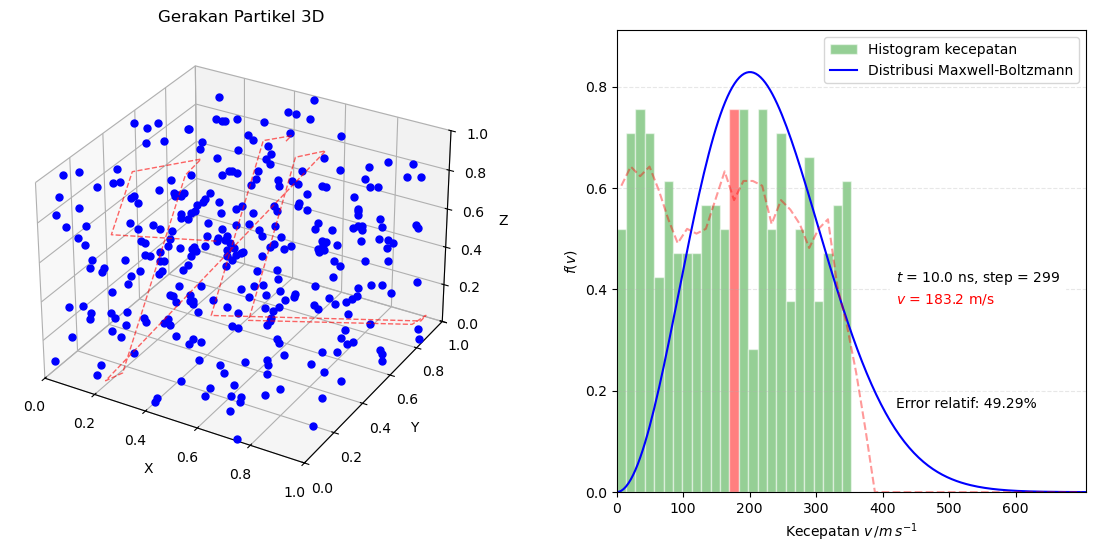

In [1]:
# Simulasi gas ideal 3D - Versi Perbaikan (Partikel Muncul + Animasi Berjalan)

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

X, Y, Z = 0, 1, 2

class GasIdeal3D:
    def __init__(self, pos, kec, r, m):
        self.pos = np.asarray(pos, dtype=float)
        self.kec = np.asarray(kec, dtype=float)
        self.n = self.pos.shape[0]
        self.r = r
        self.m = m
        self.nsteps = 0

    def advance(self, dt):
        self.nsteps += 1
        self.pos += self.kec * dt
        
        # Deteksi tumbukan antar partikel
        dist = squareform(pdist(self.pos))
        iarr, jarr = np.where(dist < 2 * self.r)
        k = iarr < jarr
        iarr, jarr = iarr[k], jarr[k]
        
        # Tumbukan dengan dinding kotak 3D
        dinding_x0 = self.pos[:, X] < self.r
        dinding_x1 = self.pos[:, X] > 1 - self.r
        dinding_y0 = self.pos[:, Y] < self.r
        dinding_y1 = self.pos[:, Y] > 1 - self.r
        dinding_z0 = self.pos[:, Z] < self.r
        dinding_z1 = self.pos[:, Z] > 1 - self.r
        
        self.kec[dinding_x0 | dinding_x1, X] *= -1
        self.kec[dinding_y0 | dinding_y1, Y] *= -1
        self.kec[dinding_z0 | dinding_z1, Z] *= -1
        
        # Tumbukan elastis antar partikel
        for i, j in zip(iarr, jarr):
            pos_i, kec_i = self.pos[i], self.kec[i]
            pos_j, kec_j = self.pos[j], self.kec[j]
            rel_pos = pos_i - pos_j
            rel_kec = kec_i - kec_j
            r_rel = rel_pos @ rel_pos
            if r_rel == 0:
                continue
            v_rel = rel_kec @ rel_pos
            v_rel = 2 * rel_pos * v_rel / r_rel - rel_kec
            v_cm = (kec_i + kec_j) / 2
            self.kec[i] = v_cm - v_rel / 2
            self.kec[j] = v_cm + v_rel / 2

def get_speeds(kec):
    return np.linalg.norm(kec, axis=1)

def get_KE(speeds, m):
    return 0.5 * m * np.sum(speeds**2)

def moving_average(data, window=5):
    pad = window // 2
    padded = np.pad(data, (pad, pad), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')

#########################################################################
# Parameter simulasi
#########################################################################
n = 300          # Lebih ringan untuk animasi 3D
skala_r = 5.e6
r = 2e-10 * skala_r
skala_t = 1e9
sbar = 353 * skala_r / skala_t
FPS = 30
dt = 1 / FPS
m = 1

np.random.seed(42)
pos = np.random.random((n, 3))  # [x, y, z] ∈ [0,1]

# Distribusi isotropik 3D
theta = np.random.random(n) * 2 * np.pi
phi = np.arccos(2 * np.random.random(n) - 1)
s0 = sbar * np.random.random(n)

kec_x = s0 * np.sin(phi) * np.cos(theta)
kec_y = s0 * np.sin(phi) * np.sin(theta)
kec_z = s0 * np.cos(phi)
kec = np.column_stack((kec_x, kec_y, kec_z))

sim = GasIdeal3D(pos, kec, r, m)
tracked_index = 0
track_history = []

# Setup figure
fig = plt.figure(figsize=(12, 6), dpi=100)
fig.canvas.manager.set_window_title("Simulasi Gas Ideal 3D - Yoyok Adisetio Laksono, 2025")
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.3)

# Subplot 1: Visualisasi 3D
ax3d = fig.add_subplot(121, projection='3d')
ax3d.set_xlim(0, 1)
ax3d.set_ylim(0, 1)
ax3d.set_zlim(0, 1)
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')
ax3d.set_title('Gerakan Partikel 3D')
particles, = ax3d.plot([], [], [], 'bo', ms=5)  # Ukuran marker lebih besar
track_line, = ax3d.plot([], [], [], 'r--', lw=1, alpha=0.6)

# Subplot 2: Histogram kecepatan
speed_ax = fig.add_subplot(122)
speed_ax.set_xlabel(r'Kecepatan $v\,/m\,s^{-1}$')
speed_ax.set_ylabel(r'$f(v)$')

speeds = get_speeds(sim.kec)
nbins = 50
hist_vals, bins, bar_container = speed_ax.hist(
    speeds, bins=nbins, range=(0, 2 * sbar), density=True,
    color='tab:green', edgecolor='w', alpha=0.5,
    label='Histogram kecepatan'
)
bar_container_ref = bar_container

speed_ax.set_xlim(0, 2 * sbar)
ticks = np.linspace(0, 600, 7, dtype=int)
speed_ax.set_xticks(ticks * skala_r / skala_t)
speed_ax.set_xticklabels([str(tick) for tick in ticks])
speed_ax.grid(axis='y', linestyle='--', alpha=0.3)

# Distribusi Maxwell-Boltzmann 3D
mean_KE = get_KE(speeds, m) / n
a = m / (2 * mean_KE)
sgrid_hi = np.linspace(0, bins[-1], 200)
f = 4 * np.pi * (a / np.pi)**1.5 * sgrid_hi**2 * np.exp(-a * sgrid_hi**2)
mb_line, = speed_ax.plot(sgrid_hi, f, 'b-', label='Distribusi Maxwell-Boltzmann')

fmax = np.max(f)
speed_ax.set_ylim(0, fmax * 1.1)
speed_ax.legend(loc='upper right')

# Elemen dinamis
sgrid = (bins[1:] + bins[:-1]) / 2
mb_est = np.zeros(len(sgrid))
mb_est_line, = speed_ax.plot([], [], 'r--', alpha=0.4)
peak_dots, = speed_ax.plot([], [], 'ro', markersize=3)

xlabel, ylabel = 0.6 * sgrid[-1], 0.5 * fmax
label = speed_ax.text(xlabel, ylabel, '', backgroundcolor='w')
speed_label = speed_ax.text(xlabel, 0.9*ylabel, '', color='red', fontsize=10, backgroundcolor='w')
error_text = speed_ax.text(xlabel, 0.4*ylabel, '', fontsize=10, color='black', backgroundcolor='w')

IAV_START = 1
frames = 300

def init_anim():
    particles.set_data([], [])
    particles.set_3d_properties([])
    track_line.set_data([], [])
    track_line.set_3d_properties([])
    mb_est_line.set_data([], [])
    peak_dots.set_data([], [])
    label.set_text('')
    speed_label.set_text('')
    error_text.set_text('')
    for patch in bar_container_ref.patches:
        patch.set_height(0)
    return (particles, track_line, mb_est_line, peak_dots, label, speed_label, error_text, 
            *bar_container_ref.patches)

def animate(i):
    global sim, mb_est, track_history, tracked_index
    
    sim.advance(dt)
    
    # Update partikel 3D
    x, y, z = sim.pos[:, X], sim.pos[:, Y], sim.pos[:, Z]
    particles.set_data(x, y)
    particles.set_3d_properties(z)
    # particles.set_markersize(5)  # Jangan ubah ukuran tiap frame

    # Update jejak partikel terpilih
    track_history.append(sim.pos[tracked_index].copy())
    if len(track_history) > 1:
        tx, ty, tz = zip(*track_history)
        track_line.set_data(tx, ty)
        track_line.set_3d_properties(tz)

    # Update histogram
    speeds = get_speeds(sim.kec)
    hist_vals, _ = np.histogram(speeds, bins=bins, density=True)
    for count, patch in zip(hist_vals, bar_container_ref.patches):
        patch.set_height(count)
        patch.set_facecolor('tab:green')

    # Sorot partikel terpilih
    tracked_speed = speeds[tracked_index]
    bin_index = np.searchsorted(bins, tracked_speed) - 1
    if 0 <= bin_index < len(bar_container_ref.patches):
        bar_container_ref.patches[bin_index].set_facecolor('red')

    # Update estimasi distribusi
    if i >= IAV_START:
        mb_est += (hist_vals - mb_est) / (i - IAV_START + 1)
        smoothed = moving_average(mb_est, window=5)
        mb_est_line.set_data(sgrid, smoothed)
        
        f_interp = 4 * np.pi * (a / np.pi)**1.5 * sgrid**2 * np.exp(-a * sgrid**2)
        error_rel = np.linalg.norm(smoothed - f_interp) / (np.linalg.norm(f_interp) + 1e-10)
        error_text.set_text(f'Error relatif: {error_rel:.2%}')

    label.set_text(f'$t$ = {i * dt:.1f} ns, step = {i}')
    speed_label.set_text(f'$v$ = {tracked_speed * skala_t / skala_r:.1f} m/s')
    
    return (particles, track_line, mb_est_line, peak_dots, label, speed_label, error_text, 
            *bar_container_ref.patches)

# Interaksi klik (sederhana)
def on_click(event):
    global tracked_index, track_history
    if event.inaxes != ax3d:
        return
    tracked_index = np.random.randint(0, n)  # pilih acak saat klik
    track_history = [sim.pos[tracked_index].copy()]

fig.canvas.mpl_connect('button_press_event', on_click)

# === SIMPAN SEBAGAI VIDEO (TANPA ERROR) ===
from matplotlib.animation import FFMpegWriter

# Pastikan ffmpeg terinstal
# conda install -c conda-forge ffmpeg

writer = FFMpegWriter(fps=30, metadata=dict(artist='Yoyok'), bitrate=1800)

print("🚀 Memulai perekaman video...")

with writer.saving(fig, "simulasi_gas_ideal_3D.mp4", dpi=100):
    for i in tqdm(range(frames), desc="Merekam frame"):
        # Panggil fungsi animate secara manual
        animate(i)
        # Simpan frame saat ini
        writer.grab_frame()

print("✅ Video berhasil disimpan sebagai 'simulasi_gas_ideal_3D.mp4'")